In [1]:
import os
import pandas as pd

In [2]:
IMAGE_DIR = "images"
FOLDERS = ["happy", "sad", "relaxed", "angry"]

In [3]:
img_files = []
labels = []
label_code = []

for folder in FOLDERS:
    fname = os.path.join(IMAGE_DIR, folder)
    
    for im in os.listdir(fname):
        impath = os.path.join(fname, im)
        
        img_files.append(impath)
        labels.append(folder)
        label_code.append(FOLDERS.index(folder))

In [4]:
import pandas as pd

dataset = pd.DataFrame(dict(filename=img_files, label=labels, code=label_code))

In [5]:
dataset

filename  label  code
0       images/happy/814630827_5f07025901_b.jpg  happy     0
1      images/happy/3485251203_8c29906dfc_b.jpg  happy     0
2        images/happy/68064855_3acb7bdb2f_b.jpg  happy     0
3      images/happy/7292844552_a9ee901faa_b.jpg  happy     0
4     images/happy/14189841729_bafff6f76e_b.jpg  happy     0
...                                         ...    ...   ...
6074  images/angry/26545086837_d41d494011_b.jpg  angry     3
6075   images/angry/4272821119_2fb5bda323_b.jpg  angry     3
6076   images/angry/9817465344_73a24fcb7e_b.jpg  angry     3
6077   images/angry/7015512467_6bd0e4e3b0_b.jpg  angry     3
6078   images/angry/5142499310_c54a82664a_b.jpg  angry     3

[6079 rows x 3 columns]

In [6]:
import torch

In [7]:
torch.cuda.is_available()

False

In [8]:
torch.backends.mps.is_available()

True

In [9]:
device = torch.device("mps")

In [10]:
from torchvision.io import read_image
from torchvision.transforms import RandomHorizontalFlip, RandomVerticalFlip, RandomRotation
from torch.utils.data import Dataset
import math

class DogDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.augments = [RandomHorizontalFlip(1), RandomRotation(90), RandomVerticalFlip(1)]

    def __len__(self):
        return self.dataset.shape[0] * (len(self.augments) + 1)
    
    def classes(self):
        return self.dataset["code"].unique()

    def __getitem__(self, idx):
        augment = math.floor(idx / self.dataset.shape[0])
        idx = idx % self.dataset.shape[0]
        
        row = self.dataset.iloc[idx,:]
            
        img_path = row["filename"]
        image = read_image(img_path)
        
        label = row["code"]
        
        if augment > 0:
            image = self.augments[augment - 1].forward(image)

        return image, int(label), img_path

In [11]:
data = DogDataset(dataset)

In [12]:
train_size = int(0.8 * len(data))
test_size = len(data) - train_size
train_data, test_data = torch.utils.data.random_split(data, [train_size, test_size], generator=torch.Generator().manual_seed(1))

In [13]:
from torch.utils.data import DataLoader

BATCH_SIZE = 64
EPOCHS = 30

train = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [14]:
from torch import nn

class NeuralNetwork(nn.Module):
    def __init__(self, classes):
        super(NeuralNetwork, self).__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 8, 4),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(8, 32, 4),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Dropout(.1),
        )
        
        self.dense = nn.Sequential(
            nn.Linear(32 * 61 * 61, 256),
            nn.ReLU(True),
            nn.Linear(256, 64),
            nn.ReLU(True),
            nn.Linear(64, len(classes))
        )

    def forward(self, x):
        x = self.cnn(x)
        x = torch.flatten(x, 1) 
        x = self.dense(x)
        return x

In [15]:
labels = data.classes()

In [16]:
model = NeuralNetwork(labels).to(device)

In [17]:
model

NeuralNetwork(
  (cnn): Sequential(
    (0): Conv2d(3, 8, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 32, kernel_size=(4, 4), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout(p=0.1, inplace=False)
  )
  (dense): Sequential(
    (0): Linear(in_features=119072, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=4, bias=True)
  )
)

In [18]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=.001)

In [19]:
size = len(train.dataset)

for epoch in range(EPOCHS):
    for batch, (images, labels, img_paths) in enumerate(train): 
        optimizer.zero_grad()
        
        images = images.to(device)
        pred = model(images.float())
        
        labels = labels.to(device)
        loss = loss_fn(pred, labels)

        loss.backward()
        optimizer.step()

    loss, current = loss.item(), batch * len(images)
    print(f"loss: {loss:>7f}  [{epoch}]")

loss: 1.375625  [0]
loss: 1.337599  [1]
loss: 1.340386  [2]
loss: 1.330358  [3]
loss: 1.292361  [4]
loss: 1.150860  [5]
loss: 0.951606  [6]
loss: 1.027077  [7]
loss: 0.679648  [8]
loss: 0.618731  [9]
loss: 0.561936  [10]
loss: 0.445886  [11]
loss: 0.402799  [12]
loss: 0.618098  [13]
loss: 0.381597  [14]
loss: 0.751166  [15]
loss: 0.369827  [16]
loss: 0.299406  [17]
loss: 0.358795  [18]
loss: 0.356256  [19]
loss: 0.416807  [20]
loss: 0.323810  [21]
loss: 0.320120  [22]
loss: 0.253219  [23]
loss: 0.371888  [24]
loss: 0.332822  [25]
loss: 0.356295  [26]
loss: 0.323094  [27]
loss: 0.273249  [28]
loss: 0.402242  [29]
loss: 0.290440  [30]
loss: 0.430628  [31]
loss: 0.326040  [32]
loss: 0.347502  [33]
loss: 0.429170  [34]


In [20]:
torch.save(model, 'dog_model.pth')

In [21]:
all_preds = list()
all_labels = list()
all_paths = list()

with torch.no_grad():
    for batch, (images, labels, img_paths) in enumerate(test):
        
        images = images.to(device)
        outputs = model(images.float())
        
        _, preds = torch.max(outputs.data, 1)
        
        all_labels.append(labels)
        all_preds.append(preds)
        all_paths.append(img_paths)

In [24]:
import numpy as np

preds = np.concatenate([p.cpu().numpy() for p in all_preds])
labels = np.concatenate([p.cpu().numpy() for p in all_labels])
paths = np.concatenate([p for p in all_paths])

In [27]:
((preds == labels).sum()) / len(labels)

0.3690378289473684

In [42]:
predictions = pd.DataFrame(dict(pred=preds, label=labels, path=paths))

In [43]:
predictions["emotion"] = predictions["pred"].apply(lambda x: FOLDERS[int(x)])

In [48]:
disp = predictions.iloc[:50,:].copy()

In [58]:
from PIL import Image
import io
import base64

In [59]:
disp["image"] = disp["path"].apply(lambda x: Image.open(x))

In [60]:
def image_formatter(img):
    with io.BytesIO() as buffer:
        img.save(buffer, 'png')
        img_str = base64.b64encode(buffer.getvalue()).decode()
        return f'<img src="data:image/jpeg;base64,{img_str}">'


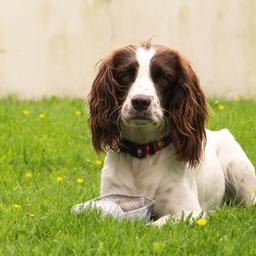
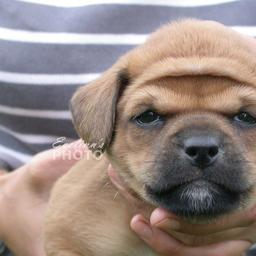
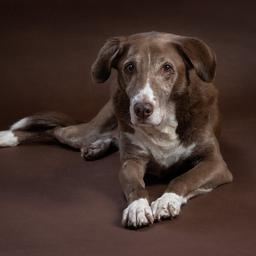
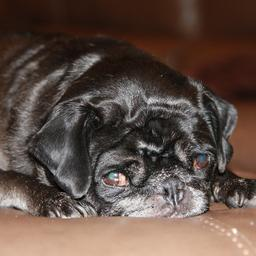
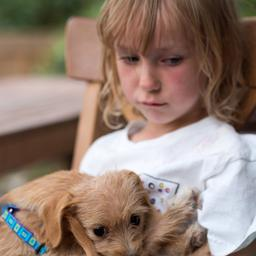
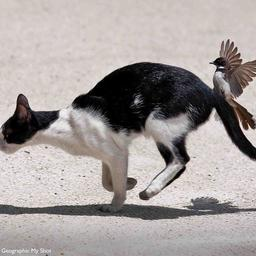
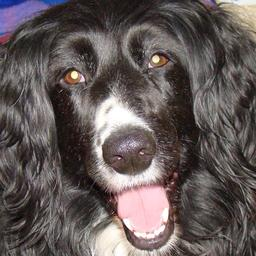
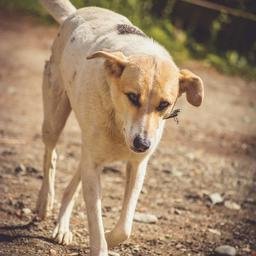
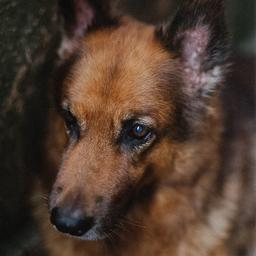
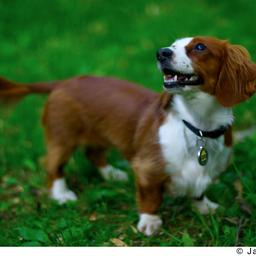
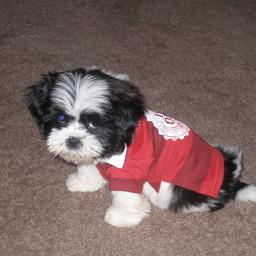
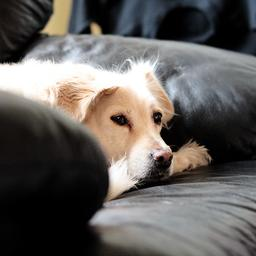
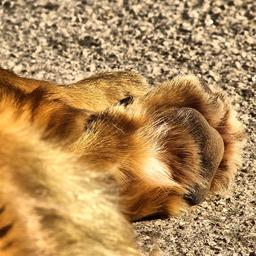
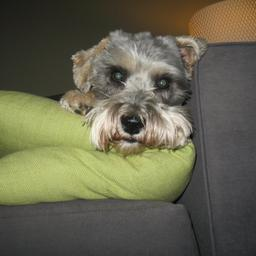
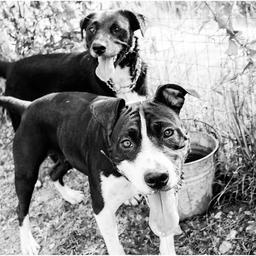
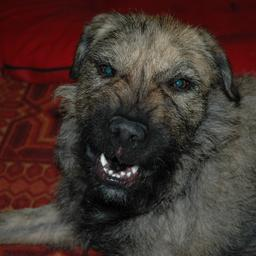
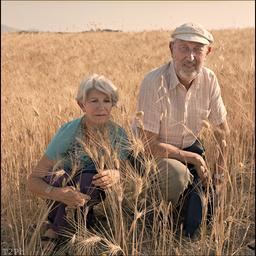
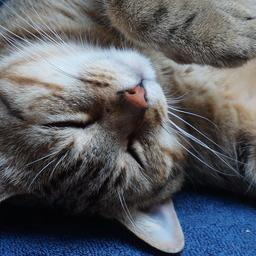
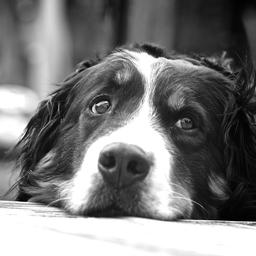
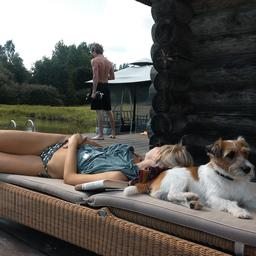
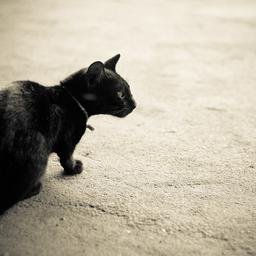
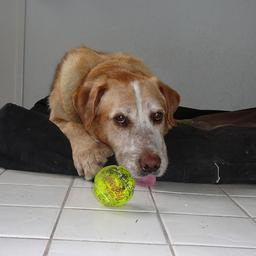
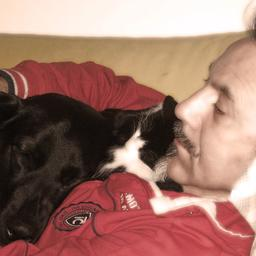
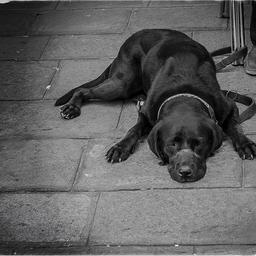
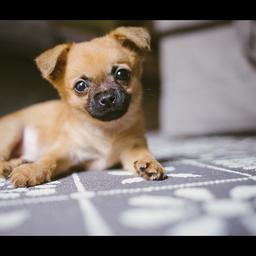
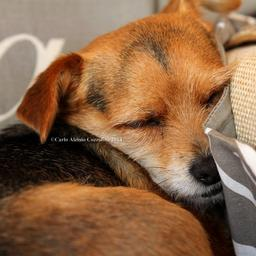
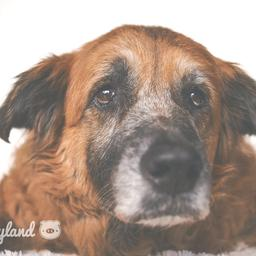
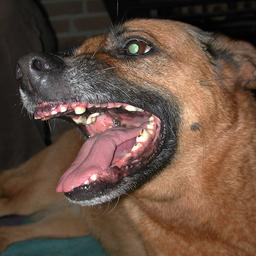
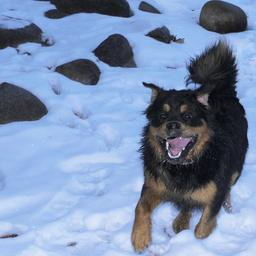
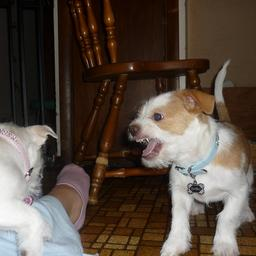
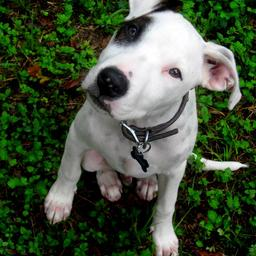
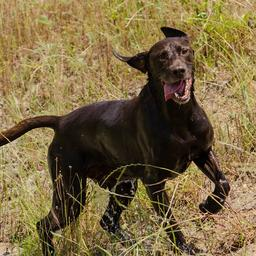
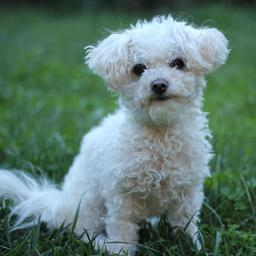
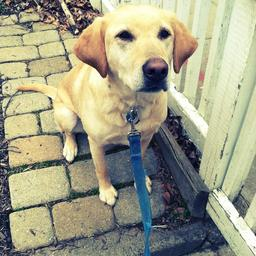
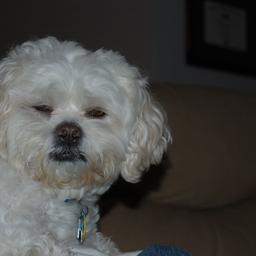
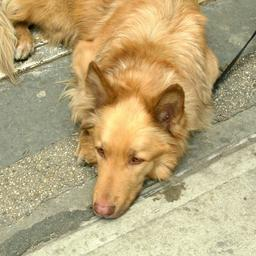
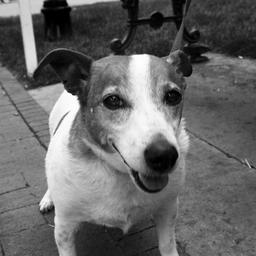
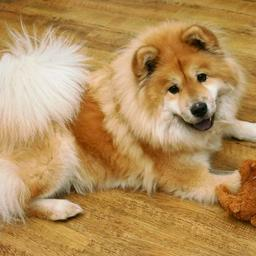
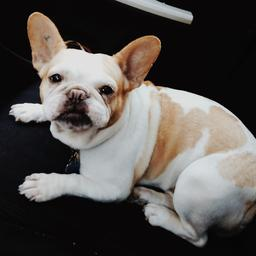
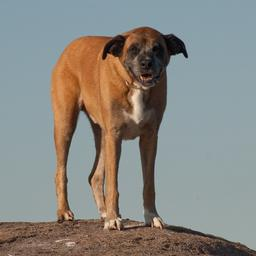
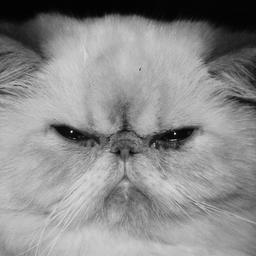
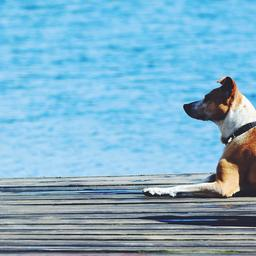
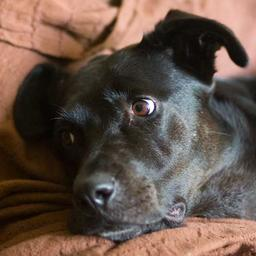
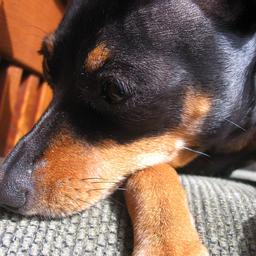
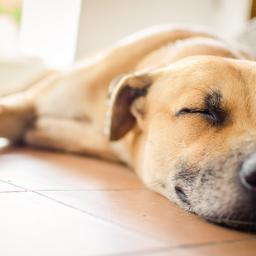
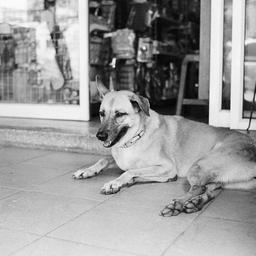
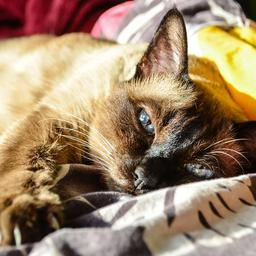
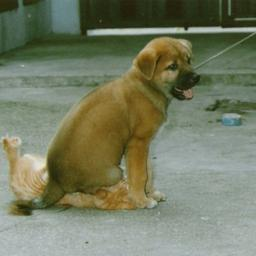
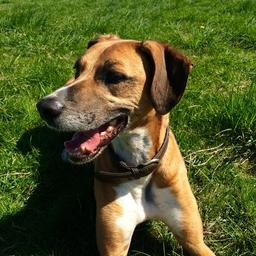
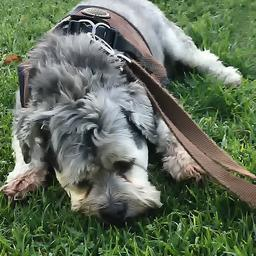

In [61]:
disp.style.format({'image': image_formatter})